# Title & Objective

# Data Loading

# Data Overview & Variable Types

## Variable Types

| Variable name | Variable type | Why it matters for credit risk |
| --- | --- | --- |
| int_rate | numerical (continuous) | Higher rates often reflect higher borrower risk and expected loss. |
| dti | numerical (continuous) | Higher debt-to-income suggests tighter cash flow and default risk. |
| loan_amnt | numerical (continuous) | Larger loans increase exposure and repayment burden. |
| grade | categorical (ordinal) | Encodes lender risk grading tied to expected default levels. |

# EDA (4 variables + business interpretation)

# Feature Engineering (≥4 engineered features)

# Train / Validation / Test strategy

# Model 1 (Algorithm + tuning + feature importance)

# Model 2 (Algorithm + tuning + feature importance)

# Model comparison

# Threshold optimization (business cost/benefit)

# Final test evaluation

# Conclusion


In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, confusion_matrix

RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)


In [7]:
train_path = "../data/lending_club_train.csv"
test_path  = "../data/lending_club_test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

df_train.shape, df_test.shape


((10129, 21), (2533, 21))

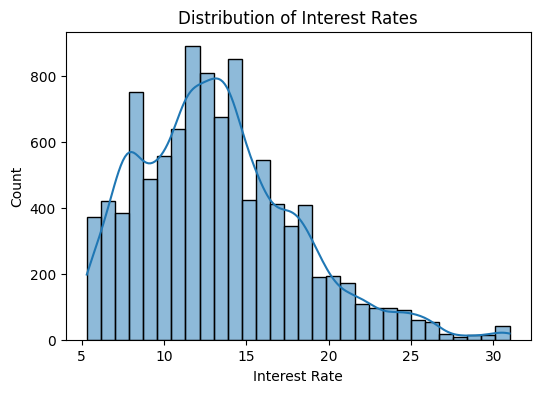

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["int_rate"], bins=30, kde=True)
plt.title("Distribution of Interest Rates")
plt.xlabel("Interest Rate")
plt.ylabel("Count")
plt.show()


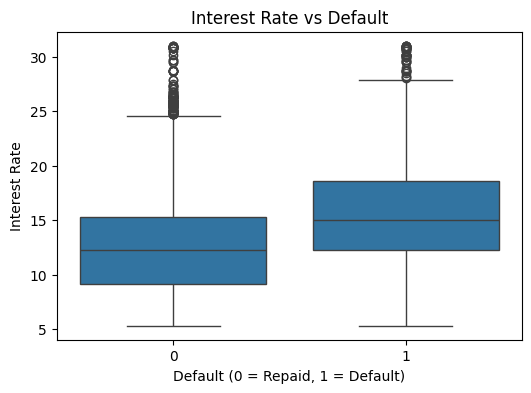

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x="default", y="int_rate", data=df_train)
plt.title("Interest Rate vs Default")
plt.xlabel("Default (0 = Repaid, 1 = Default)")
plt.ylabel("Interest Rate")
plt.show()


**Interest Rate (`int_rate`)**

The interest rate reflects the lender’s assessment of borrower risk at origination.
The distribution shows a wide range of rates, with higher interest rates being more frequent among loans that eventually defaulted.
This suggests that interest rates already embed risk information and are strongly associated with default probability.


In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["dti"], bins=30, kde=True)
plt.title("Distribution of Debt-to-Income Ratio (DTI)")
plt.xlabel("DTI")
plt.ylabel("Count")
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x="default", y="dti", data=df_train)
plt.title("DTI vs Default")
plt.xlabel("Default (0 = Repaid, 1 = Default)")
plt.ylabel("Debt-to-Income Ratio")
plt.show()


**Debt-to-Income Ratio (`dti`)**

The debt-to-income ratio measures the proportion of a borrower’s income already committed to debt obligations.
Higher DTI values indicate greater financial strain and reduced repayment capacity.
The analysis shows that defaulted loans tend to have higher DTI levels, confirming DTI as a key risk driver in credit decisions.


In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df_train["loan_amnt"], bins=30, kde=True)
plt.title("Distribution of Loan Amount")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x="default", y="loan_amnt", data=df_train)
plt.title("Loan Amount vs Default")
plt.xlabel("Default (0 = Repaid, 1 = Default)")
plt.ylabel("Loan Amount")
plt.show()


**Loan Amount (`loan_amnt`)**

The loan amount represents the size of the lender’s exposure rather than the borrower’s intrinsic credit quality.
The distribution shows a concentration around mid-sized loans.
The relationship with default appears weaker than for interest rate or DTI, suggesting that loan size alone is not a primary driver of default, but may interact with income or other risk factors.


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="grade", data=df_train, order=sorted(df_train["grade"].unique()))
plt.title("Distribution of Credit Grades")
plt.xlabel("Credit Grade")
plt.ylabel("Count")
plt.show()


In [ ]:
grade_default_rate = (
    df_train
    .groupby("grade")["default"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(x="grade", y="default", data=grade_default_rate,
            order=sorted(grade_default_rate["grade"]))
plt.title("Average Default Rate by Credit Grade")
plt.xlabel("Credit Grade")
plt.ylabel("Default Rate")
plt.show()


**Credit Grade (`grade`)**

The credit grade is an ordinal categorical variable summarizing the lender’s internal credit assessment at origination.
Lower grades are associated with significantly higher default rates, while higher grades exhibit substantially lower default frequencies.
This clear monotonic relationship confirms that `grade` is one of the strongest predictors of default and validates its economic relevance in credit risk modeling.


In [10]:
df_train.head()


,id,loan_amnt,term,int_rate,installment,grade,sub_grade,annual_inc,emp_length,home_ownership,verification_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,purpose,default
0,79044496,16000.0,60.0,12.99,363.97,C,C2,49000.0,5.0,RENT,Source Verified,15.94,0.0,0.0,9.0,0.0,26376.0,85.4,19.0,debt_consolidation,0
1,43246030,15150.0,36.0,10.99,495.92,B,B4,38000.0,8.0,MORTGAGE,Not Verified,39.96,1.0,1.0,10.0,0.0,19459.0,63.2,38.0,credit_card,0
2,641694,12800.0,60.0,14.83,303.38,D,D3,75000.0,0.0,RENT,Source Verified,12.43,0.0,0.0,12.0,0.0,8078.0,35.0,13.0,moving,0
3,70981628,6000.0,36.0,9.75,192.90,B,B3,70000.0,0.0,MORTGAGE,Verified,25.53,1.0,1.0,9.0,0.0,2048.0,39.4,16.0,debt_consolidation,0
4,57792301,15000.0,60.0,13.33,343.84,C,C3,96000.0,3.0,RENT,Source Verified,13.44,0.0,0.0,11.0,1.0,15979.0,53.3,36.0,debt_consolidation,0


In [11]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10129 non-null  int64  
 1   loan_amnt            10129 non-null  float64
 2   term                 10129 non-null  float64
 3   int_rate             10129 non-null  float64
 4   installment          10129 non-null  float64
 5   grade                10129 non-null  object 
 6   sub_grade            10129 non-null  object 
 7   annual_inc           10129 non-null  float64
 8   emp_length           10129 non-null  float64
 9   home_ownership       10129 non-null  object 
 10  verification_status  10129 non-null  object 
 11  dti                  10129 non-null  float64
 12  delinq_2yrs          10129 non-null  float64
 13  inq_last_6mths       10129 non-null  float64
 14  open_acc             10129 non-null  float64
 15  pub_rec              10129 non-null 

In [12]:
df_train.dtypes


id                       int64
loan_amnt              float64
term                   float64
int_rate               float64
installment            float64
grade                   object
sub_grade               object
annual_inc             float64
emp_length             float64
home_ownership          object
verification_status     object
dti                    float64
delinq_2yrs            float64
inq_last_6mths         float64
open_acc               float64
pub_rec                float64
revol_bal              float64
revol_util             float64
total_acc              float64
purpose                 object
default                  int64
dtype: object